# Computational Finance

In [9]:
!pip install yahoofinancials

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from yahoofinancials import YahooFinancials

In [11]:
sns.set(rc={'figure.figsize':(9, 4)})

## Time Series Data

In [12]:
df = YahooFinancials('MSFT').get_historical_price_data(start_date='2017-01-01', end_date='2019-12-31', 
                                                  time_interval='daily')
df = pd.DataFrame(df['MSFT']['prices'])
df['Date'] = df['formatted_date']
df = df.drop(['date','formatted_date'], axis=1)
df = df.set_index('Date')
df.head()

,high,low,open,close,volume,adjclose
Date,,,,,,
2017-01-03,62.840000,62.130001,62.790001,62.580002,20694100,58.291969
2017-01-04,62.750000,62.119999,62.480000,62.299999,21340000,58.031147
2017-01-05,62.660000,62.029999,62.189999,62.299999,24876000,58.031147
2017-01-06,63.150002,62.040001,62.299999,62.840000,19922900,58.534157
2017-01-09,63.080002,62.540001,62.759998,62.639999,20382700,58.347855


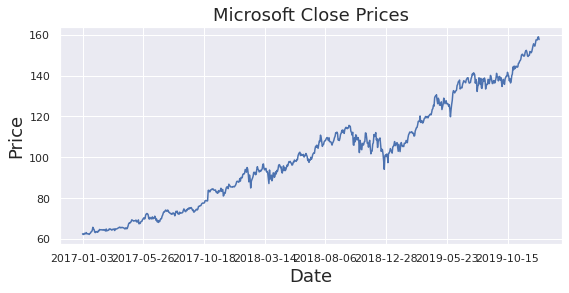

In [13]:
df['close'].plot();
plt.xlabel("Date", fontsize=18);
plt.ylabel("Price", fontsize=18);
plt.title('Microsoft Close Prices', fontsize=18);
plt.savefig("1.png", format='png', dpi=1200, bbox_inches='tight')

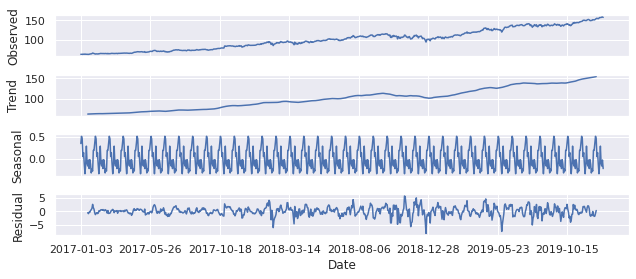

In [14]:
seasonal_decompose(df['close'], model='additive', freq=20).plot();
plt.savefig("2.png", format='png', dpi=1200, bbox_inches='tight');

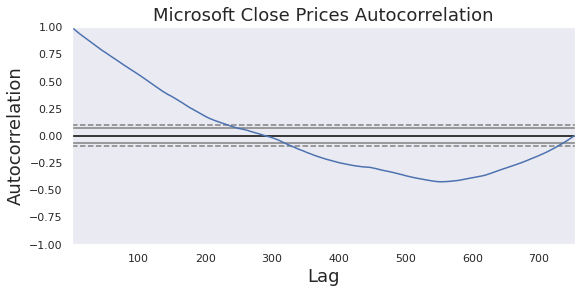

In [15]:
autocorrelation_plot(df['close']);
plt.xlabel("Lag", fontsize=18);
plt.ylabel("Autocorrelation", fontsize=18);
plt.title('Microsoft Close Prices Autocorrelation', fontsize=18);
plt.savefig("3.png", format='png', dpi=1200, bbox_inches='tight')

## Modern Portfolio Theory

In [16]:
df = YahooFinancials(['AAPL', 'MSFT', 'FB']).get_historical_price_data(start_date='2017-01-01', 
                                                                       end_date='2019-12-31', 
                                                                       time_interval='daily')
df = pd.DataFrame({'Date' :pd.DataFrame(df['AAPL']['prices'])['formatted_date'],
                   'AAPL' :pd.DataFrame(df['AAPL']['prices'])['adjclose'],
                   'MSFT' :pd.DataFrame(df['MSFT']['prices'])['adjclose'],
                   'FB' :pd.DataFrame(df['FB']['prices'])['adjclose']})
df = df.set_index('Date')
df.head()

,AAPL,MSFT,FB
Date,,,
2017-01-03,27.372362,58.291969,116.860001
2017-01-04,27.341724,58.031147,118.690002
2017-01-05,27.480770,58.031147,120.669998
2017-01-06,27.787130,58.534157,123.410004
2017-01-09,28.041647,58.347855,124.900002


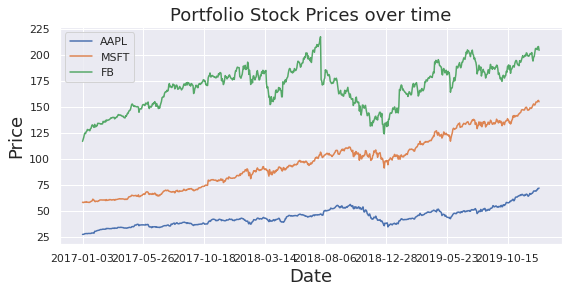

In [17]:
df['AAPL'].plot();
df['MSFT'].plot();
df['FB'].plot();
plt.legend(['AAPL', 'MSFT', 'FB'])
plt.xlabel("Date", fontsize=18);
plt.ylabel("Price", fontsize=18);
plt.title('Portfolio Stock Prices over time', fontsize=18);
plt.savefig("4.png", format='png', dpi=1200, bbox_inches='tight')

In [18]:
def portfolio_return_sim(df, daily_mean_returns, daily_cov_matrix, rf_rate, itern, working_days=252):
    number_of_stocks = df.shape[1]
    sim_res = np.zeros((3, itern))
    list_weights = []
    for i in range(itern):
        random_weights = np.random.random(number_of_stocks)
        normalized_weights = random_weights/np.sum(random_weights)
        list_weights.append([np.round(i, 3) for i in normalized_weights])
        port_annual_return = np.sum(daily_mean_returns*normalized_weights) * working_days 
        port_annual_std = np.sqrt(np.dot(normalized_weights.T, np.dot(daily_cov_matrix, 
                                                           normalized_weights))) * np.sqrt(working_days)
        sim_res[0,i], sim_res[1,i] = port_annual_std, port_annual_return
        sim_res[2,i] = (port_annual_return - rf_rate) / port_annual_std
    
    min_risk, max_sharpe = np.argmin(sim_res[0]), np.argmax(sim_res[2])
    plt.scatter(sim_res[0,:], sim_res[1,:], c=sim_res[2,:], cmap='cividis', marker='.')
    plt.colorbar(orientation='vertical')
    plt.scatter(sim_res[0, min_risk], sim_res[1, min_risk], 
                marker='x', color='r', s=300, label='Minimum Risk')
    plt.scatter(sim_res[0, max_sharpe], sim_res[1, max_sharpe], 
                marker='x', color='b', s=300, label='Maximum Sharpe Ratio')
    plt.legend(labelspacing=0.7)
    plt.title('Monte Carlo Simulated Portfolio Optimization', fontsize=18)
    plt.xlabel('Annual Risk (Variation)', fontsize=18)
    plt.ylabel('Annual Return', fontsize=18)
    plt.savefig("5.png", format='png', dpi=1200, bbox_inches='tight')
    plt.show()
    
    df2 = pd.DataFrame([list_weights[min_risk], list_weights[max_sharpe]], 
                       columns=df.columns, index=["Minimum Risk Portfolio", 
                                                  "Maximum Sharpe Portfolio"])
    return df2

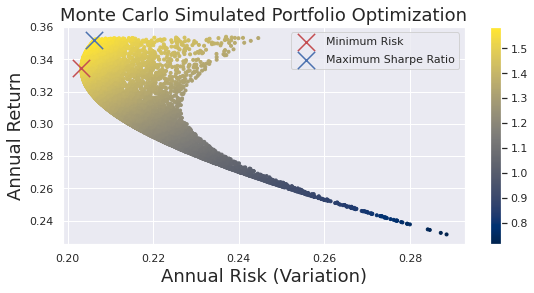

,AAPL,MSFT,FB
Minimum Risk Portfolio,0.286,0.569,0.146
Maximum Sharpe Portfolio,0.335,0.663,0.002


In [19]:
daily_returns = df.pct_change()
df2 = portfolio_return_sim(df, daily_returns.mean(), daily_returns.cov(), 0.025, 10000)
df2.head()